# Proyecto Redes Neuronales: Perceptrón Multicapa con PyTorch

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo MLP usando PyTorch (Entrega 1 - refactorización)  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Componentes implementados:
1. Configuración de Parámetros Globales
2. Carga y Preprocesamiento de Datos con PyTorch
3. Construcción del Modelo MLP en PyTorch
4. Entrenamiento con Early Stopping
5. Evaluación del Modelo
6. Visualización de Resultados
7. Guardado de Experimentos

## 0. Configuración de Parámetros Globales

In [3]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====

# Configuración general del experimento
EXPERIMENT_NAME = "MLP_PyTorch_BoW"
MODEL_TYPE = "MLP_BoW_Torch"
RANDOM_SEED = 42
PROJECT_PART = "project_part_1"

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Configuración del dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"  # None para todos
USE_TITLE_AND_BODY = True

# Parámetros de preprocesamiento BoW/TF-IDF
MAX_FEATURES = 5000
MIN_DF = 3
MAX_DF = 0.85

# Arquitectura del modelo
HIDDEN_LAYERS = [256, 128, 64]
DROPOUT_RATE = 0.3

# Parámetros de entrenamiento
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.001
PATIENCE = 10

print(f"=== Configuración: {EXPERIMENT_NAME} ===")
print(f"Framework: PyTorch")
print(f"Proyecto: {PROJECT_PART}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print("="*60)

=== Configuración: MLP_PyTorch_BoW ===
Framework: PyTorch
Proyecto: project_part_1
Idioma: en
Arquitectura: [256, 128, 64]


## 1. Importación de Librerías

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers directamente desde sus módulos
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import MLPClassifier
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)
print(f"GPU disponible: {gpu_info['gpu_available']}")
if gpu_info['gpu_available']:
    print(f"GPU: {gpu_info['gpu_names']}")
    print(f"CUDA: {gpu_info['cuda_version']}")

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070
GPU disponible: True
GPU: ['NVIDIA GeForce RTX 5070']
CUDA: 13.0


## 2. Carga y Preprocesamiento de Datos

In [5]:
# Cargar datos
data_loader = DataLoaderTorch(data_dir=DATA_DIR)
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales:")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE and LANGUAGE_COLUMN in train_df.columns:
    print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
    train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    print(f"Filtrados: Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Distribución de clases
print(f"\nDistribución de clases:")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    print(f"  {stars} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales:
Train: 1,200,000, Val: 30,000, Test: 30,000

Filtrando por idioma: en
Filtrados: Train: 200,000, Val: 5,000, Test: 5,000

Distribución de clases:
  1 estrellas: 40,000 (20.0%)
  2 estrellas: 40,000 (20.0%)
  3 estrellas: 40,000 (20.0%)
  4 estrellas: 40,000 (20.0%)
  5 estrellas: 40,000 (20.0%)
Filtrados: Train: 200,000, Val: 5,000, Test: 5,000

Distribución de clases:
  1 estrellas: 40,000 (20.0%)
  2 estrellas: 40,000 (20.0%)
  3 estrellas: 40,000 (20.0%)
  4 estrellas: 40,000 (20.0%)
  5 estrellas: 40,000 (20.0%)


## 3. Preprocesamiento con PyTorch

In [6]:
# Preprocesar datos
print("\nPreprocesando con PyTorch...")
processed = data_loader.preprocess_text_data_bow(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_features=MAX_FEATURES,
    min_df=MIN_DF,
    max_df=MAX_DF,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer info
train_loader = processed['train_loader']
val_loader = processed['val_loader']
test_loader = processed['test_loader']
num_classes = processed['num_classes']
vocab_size = processed['vocab_size']

print(f"\nVocabulario: {vocab_size}")
print(f"Clases: {num_classes}")
print(f"Sparsity: {processed['sparsity']:.1%}")

class_names = [str(i) for i in data_loader.label_encoder.classes_]


Preprocesando con PyTorch...
Preprocesando datos con BoW para PyTorch...
Configuración: max_features=5000, min_df=3, max_df=0.85
Ajustando vocabulario...
Vocabulario: 5000 características
Número de clases: 5
Sparsity: 99.70%
Muestras - Train: 200000, Val: 5000, Test: 5000
Vocabulario: 5000 características
Número de clases: 5
Sparsity: 99.70%
Muestras - Train: 200000, Val: 5000, Test: 5000

Vocabulario: 5000
Clases: 5
Sparsity: 99.7%

Vocabulario: 5000
Clases: 5
Sparsity: 99.7%


## 4. Construcción del Modelo PyTorch

In [7]:
# Crear modelo
print("\nCreando modelo PyTorch...")
model = MLPClassifier(
    input_dim=vocab_size,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Parámetros: {total_params:,}")
print(f"Arquitectura: {HIDDEN_LAYERS}")


Creando modelo PyTorch...
Parámetros: 2,602,314
Arquitectura: [256, 128, 64]


## 5. Configuración de Entrenamiento

In [9]:
# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=PATIENCE//2
)

print("\nConfiguración:")
print(f"Optimizador: Adam (lr={LEARNING_RATE})")
print(f"Loss: CrossEntropyLoss")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience={PATIENCE//2})")


Configuración:
Optimizador: Adam (lr=0.001)
Loss: CrossEntropyLoss
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## 6. Entrenamiento

In [10]:
# Entrenar
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

print("\nIniciando entrenamiento...")
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    scheduler=scheduler
)

print(f"\nEntrenamiento completado:")
print(f"Épocas: {training_results['epochs_trained']}")
print(f"Tiempo: {training_results['training_time']:.1f}s")
print(f"Mejor Val Acc: {training_results['best_val_accuracy']:.4f}")

# Guardar componentes
model_name = os.path.basename(training_results['model_path']).replace('.pth', '')
save_model_components_torch(
    model_name=model_name,
    model=model,
    vectorizer=data_loader.vectorizer,
    label_encoder=data_loader.label_encoder,
    model_dir=MODEL_DIR
)

Usando dispositivo: cuda

Iniciando entrenamiento...

Entrenando MLP_BoW_Torch_20251128_111946...
Parámetros totales: 2,602,314
Parámetros entrenables: 2,602,314


Epoch 1/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 204.59it/s, loss=0.7375, acc=53.08%]




Epoch 1/50:
  Train Loss: 1.1659, Train Acc: 0.4871
  Val Loss: 1.0740, Val Acc: 0.5308
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 1.0740)


Epoch 2/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 215.92it/s, loss=0.7674, acc=53.32%]



Epoch 2/50:
  Train Loss: 1.0435, Train Acc: 0.5505
  Val Loss: 1.0689, Val Acc: 0.5332
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 1.0689)


Epoch 3/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 223.76it/s, loss=0.8345, acc=53.22%]



Epoch 3/50:
  Train Loss: 0.9971, Train Acc: 0.5744
  Val Loss: 1.0737, Val Acc: 0.5322
  Learning Rate: 0.001000
  Épocas sin mejora: 1/10


Epoch 4/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 219.46it/s, loss=0.7961, acc=52.62%]



Epoch 4/50:
  Train Loss: 0.9353, Train Acc: 0.6044
  Val Loss: 1.1003, Val Acc: 0.5262
  Learning Rate: 0.001000
  Épocas sin mejora: 2/10


Epoch 5/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 218.94it/s, loss=0.8732, acc=52.22%]



Epoch 5/50:
  Train Loss: 0.8543, Train Acc: 0.6436
  Val Loss: 1.1474, Val Acc: 0.5222
  Learning Rate: 0.001000
  Épocas sin mejora: 3/10


Epoch 6/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 223.66it/s, loss=0.9496, acc=51.84%]



Epoch 6/50:
  Train Loss: 0.7628, Train Acc: 0.6880
  Val Loss: 1.2055, Val Acc: 0.5184
  Learning Rate: 0.001000
  Épocas sin mejora: 4/10


Epoch 7/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 226.03it/s, loss=0.9742, acc=51.70%]



Epoch 7/50:
  Train Loss: 0.6787, Train Acc: 0.7266
  Val Loss: 1.2923, Val Acc: 0.5170
  Learning Rate: 0.001000
  Épocas sin mejora: 5/10


Epoch 8/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 202.03it/s, loss=1.0357, acc=51.22%]



Epoch 8/50:
  Train Loss: 0.6097, Train Acc: 0.7583
  Val Loss: 1.3881, Val Acc: 0.5122
  Learning Rate: 0.000500
  Épocas sin mejora: 6/10


Epoch 9/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 224.00it/s, loss=1.2426, acc=50.38%]



Epoch 9/50:
  Train Loss: 0.5011, Train Acc: 0.8061
  Val Loss: 1.5623, Val Acc: 0.5038
  Learning Rate: 0.000500
  Épocas sin mejora: 7/10


Epoch 10/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 221.47it/s, loss=1.3059, acc=50.36%]



Epoch 10/50:
  Train Loss: 0.4470, Train Acc: 0.8304
  Val Loss: 1.6240, Val Acc: 0.5036
  Learning Rate: 0.000500
  Épocas sin mejora: 8/10


Epoch 11/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 223.95it/s, loss=1.4051, acc=50.08%]



Epoch 11/50:
  Train Loss: 0.4077, Train Acc: 0.8458
  Val Loss: 1.7375, Val Acc: 0.5008
  Learning Rate: 0.000500
  Épocas sin mejora: 9/10


Epoch 12/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 225.80it/s, loss=1.3776, acc=50.10%]




Epoch 12/50:
  Train Loss: 0.3741, Train Acc: 0.8600
  Val Loss: 1.8052, Val Acc: 0.5010
  Learning Rate: 0.000500
  Épocas sin mejora: 10/10

Early stopping en época 12

Mejor modelo restaurado
Modelo guardado en: models/project_part_1/MLP_BoW_Torch_20251128_111946.pth

Entrenamiento completado:
Épocas: 12
Tiempo: 28.7s
Mejor Val Acc: 0.5332
Modelo guardado: models/project_part_1/MLP_BoW_Torch_20251128_111946.pth
Vectorizador guardado: models/project_part_1/MLP_BoW_Torch_20251128_111946_vectorizer.pkl
Label encoder guardado: models/project_part_1/MLP_BoW_Torch_20251128_111946_label_encoder.pkl
Componentes guardados en models/project_part_1/


## 7. Visualización

Gráfico de historial de entrenamiento guardado en: output/project_part_1/MLP_BoW_Torch_training.png


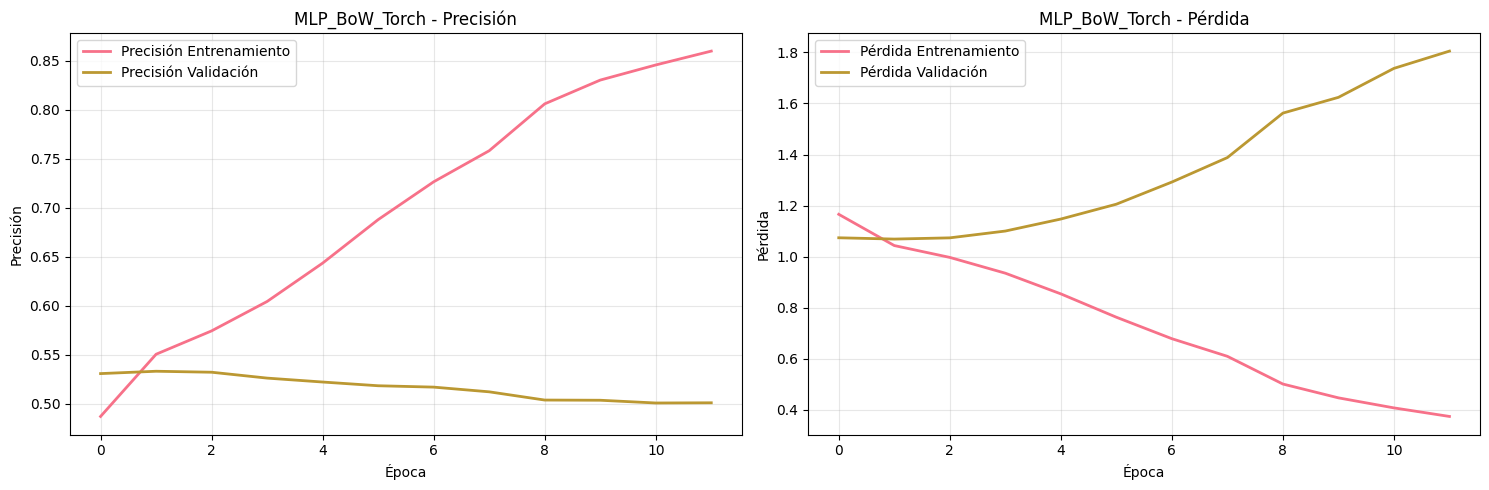

In [11]:
# Visualizar historial
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training.png"),
    framework="pytorch"
)

## 8. Evaluación

In [12]:
# Evaluar
eval_results = evaluate_model_torch(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=trainer.device,
    class_names=class_names
)

test_accuracy = eval_results['test_accuracy']
test_loss = eval_results['test_loss']
y_true = eval_results['y_true']
y_pred = eval_results['y_pred']

classification_rep = classification_report(y_true, y_pred, 
                                          target_names=class_names, 
                                          output_dict=True)

print(f"\nResultados:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...
Precisión de Prueba: 0.5092
Pérdida de Prueba: 1.7800

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.64      0.65      0.65      1000
           2       0.42      0.43      0.43      1000
           3       0.39      0.39      0.39      1000
           4       0.46      0.42      0.44      1000
           5       0.62      0.66      0.64      1000

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.51      5000
weighted avg       0.51      0.51      0.51      5000


Resultados:
Accuracy: 0.5092
Loss: 1.7800
F1 (macro): 0.5082


## 9. Matriz de Confusión

Matriz de confusión guardada en: output/project_part_1/MLP_BoW_Torch_confusion.png


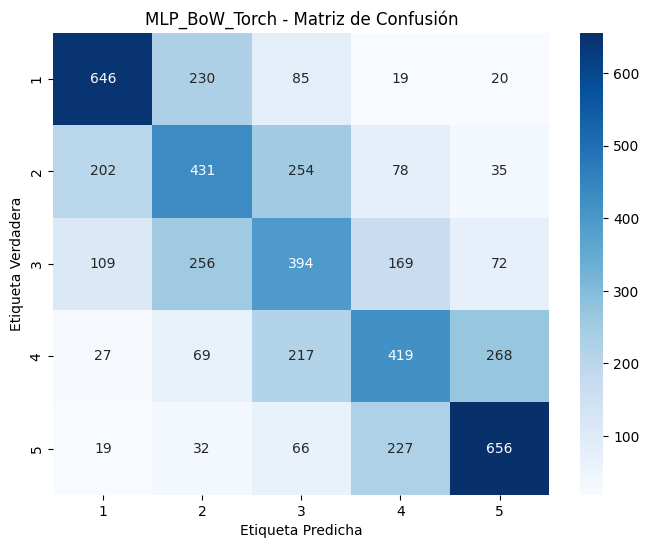

In [13]:
# Matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion.png")
)

## 10. Guardar Experimento

In [14]:
# Preparar datos del experimento
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_features': MAX_FEATURES,
        'hidden_layers': HIDDEN_LAYERS,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict()
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Proyecto: {PROJECT_PART}")
print(f"Modelo: {training_results['model_path']}")

Experiment 1 results saved to output/project_part_1/experiment_history.json

Experimento #1 guardado
Proyecto: project_part_1
Modelo: models/project_part_1/MLP_BoW_Torch_20251128_111946.pth


## 11. Resumen

In [15]:
# Resumen
print(f"\n{'='*60}")
print(f"RESUMEN - Experimento #{experiment_id}")
print(f"{'='*60}")
print(f"Framework: PyTorch")
print(f"Modelo: {MODEL_TYPE}")
print(f"Parámetros: {total_params:,}")
print(f"\nDatos: Train {len(train_df):,}, Val {len(val_df):,}, Test {len(test_df):,}")
print(f"\nResultados:")
print(f"  Test Acc: {test_accuracy:.4f}")
print(f"  F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"\nHardware: {'GPU' if gpu_info['gpu_available'] else 'CPU'}")
print(f"{'='*60}")


RESUMEN - Experimento #1
Framework: PyTorch
Modelo: MLP_BoW_Torch
Parámetros: 2,602,314

Datos: Train 200,000, Val 5,000, Test 5,000

Resultados:
  Test Acc: 0.5092
  F1 (macro): 0.5082

Hardware: GPU


## 12. Historial

In [16]:
# Ver historial
results_mgr.display_experiment_history()


HISTORIAL DE EXPERIMENTOS (1 experimentos)

ID  Modelo          Lang   Precisión  Pérdida    Épocas   Tiempo (s) Muestras  
-----------------------------------------------------------------------------------------------
1   MLP_BoW_Torch   en     0.5010     1.8052     12       28.7       200,000   

BEST EXPERIMENTS BY LANGUAGE:
--------------------------------------------------
en    : ID #1 - Accuracy: 0.5010 (200,000 samples)

OVERALL BEST: ID #1 (en) - Accuracy: 0.5010
